In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib
matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

In [2]:
from function import *

In [3]:
df = make_data(dt=0.01, total_time = 50)

In [4]:
df

,u,time,f
0,0.000000e+00,0.00,0.000000
1,6.279052e-02,0.01,0.152729
2,1.253332e-01,0.02,0.272857
3,1.873813e-01,0.03,0.369560
4,2.486899e-01,0.04,0.449713
...,...,...,...
4996,-2.486899e-01,49.96,0.299277
4997,-1.873813e-01,49.97,0.338483
4998,-1.253332e-01,49.98,0.375216
4999,-6.279052e-02,49.99,0.410140


In [5]:
train = df.iloc[:int(len(df)*0.8)]
test = df.iloc[int(len(df)*0.8):]

In [6]:
train_x = train.iloc[:, :2].values
train_y = train.iloc[:, 2].values
test_x = test.iloc[:, :2].values
test_y = test.iloc[:, 2].values

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
scaler = StandardScaler()

In [9]:
sc_train_x = scaler.fit_transform(train_x)
sc_test_x = scaler.transform(test_x)

sc_train_y = scaler.fit_transform(train_y.reshape(-1, 1))
sc_test_y = scaler.transform(test_y.reshape(-1, 1))

In [1]:
import tensorflow as tf

if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU not available")


GPU not available


In [ ]:
model = hysterisis_curve(sc_train_x, sc_train_y, sc_test_x, sc_test_y)

In [ ]:
model.dnn_fit(epochs=100, batch_size=1)

In [ ]:
pred = model.dnn_predict()

32/32 [==============================] - 0s 774us/step


In [ ]:
real_pred = scaler.inverse_transform(pred)

In [ ]:
test_x[:,0]

array([-9.79717439e-15,  6.27905195e-02,  1.25333234e-01, ...,
       -1.25333234e-01, -6.27905195e-02,  1.96438672e-15])

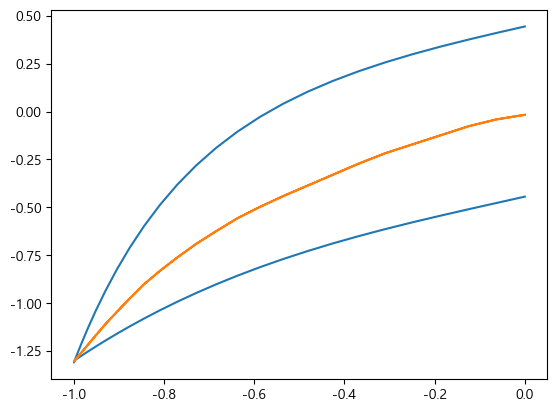

In [ ]:
plt.plot(test_x[950:,0], test_y[950:], label='real')
plt.plot(test_x[950:,0], real_pred.reshape(1,-1)[0][950:], label='pred')

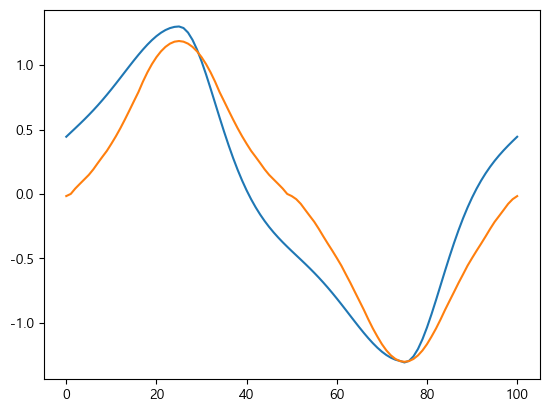

In [ ]:
plt.plot(test_y[900:])
plt.plot(real_pred.reshape(1,-1)[0][900:])
plt.show()

In [ ]:
lstm_history = model.lstm_fit(epochs=100, batch_size=1)

Epoch 1/100
4000/4000 [==============================] - 10s 2ms/step - loss: 0.2002 - mse: 0.2002
Epoch 2/100
4000/4000 [==============================] - 8s 2ms/step - loss: 0.1699 - mse: 0.1699
Epoch 3/100
4000/4000 [==============================] - 8s 2ms/step - loss: 0.1669 - mse: 0.1669
Epoch 4/100
4000/4000 [==============================] - 8s 2ms/step - loss: 0.1655 - mse: 0.1655
Epoch 5/100
4000/4000 [==============================] - 8s 2ms/step - loss: 0.1644 - mse: 0.1644
Epoch 6/100
4000/4000 [==============================] - 8s 2ms/step - loss: 0.1646 - mse: 0.1646
Epoch 7/100
4000/4000 [==============================] - 7s 2ms/step - loss: 0.1642 - mse: 0.1642
Epoch 8/100
4000/4000 [==============================] - 7s 2ms/step - loss: 0.1630 - mse: 0.1630
Epoch 9/100
4000/4000 [==============================] - 7s 2ms/step - loss: 0.1623 - mse: 0.1623
Epoch 10/100
4000/4000 [==============================] - 7s 2ms/step - loss: 0.1627 - mse: 0.1627
Epoch 11/100
4000/

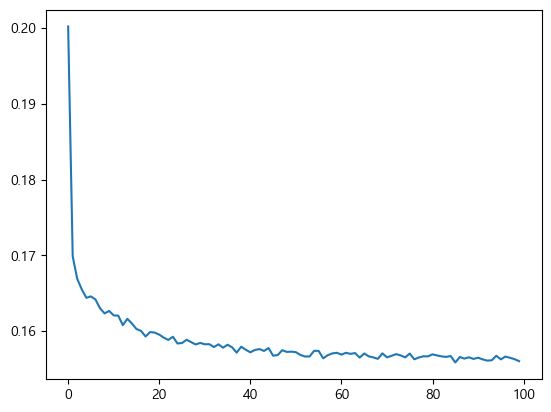

In [ ]:
plt.plot(lstm_history.history.history['loss'])

In [ ]:
lstm_pred = model.lstm_predict()

32/32 [==============================] - 1s 2ms/step


In [ ]:
real_lstm_pred = scaler.inverse_transform(lstm_pred)

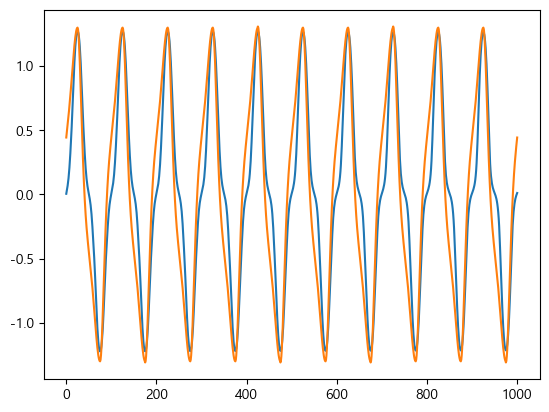

In [ ]:
plt.plot(real_lstm_pred.reshape(1,-1)[0])
plt.plot(test_y)

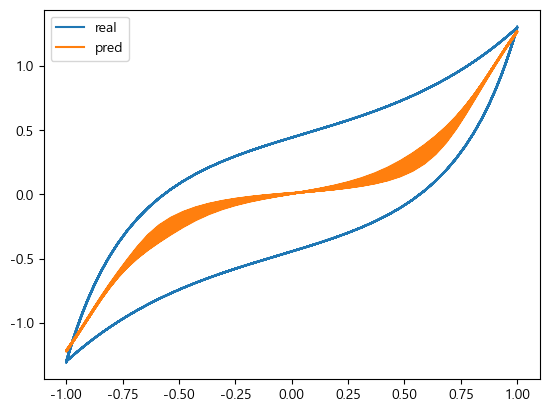

In [ ]:
plt.plot(test_x[:,0], test_y, label='real')
plt.plot(test_x[:,0], real_lstm_pred, label='pred')
plt.legend()
plt.show()

In [ ]:
import scipy

In [ ]:
class PINN_BoucWen(tf.keras.Model):
    def __init__(self, output_dim):
        super().__init__()
        self.hidden_layer_1 = tf.keras.layers.Dense(units=256, activation=tf.nn.relu)
        self.hidden_layer_2 = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)
        self.output_layer_z = tf.keras.layers.Dense(units=1)  # To predict z
        self.output_layer_f = tf.keras.layers.Dense(units=output_dim)  # To predict F(t)

    def call(self, inputs):
        x = self.hidden_layer_1(inputs)
        x = self.hidden_layer_2(x)
        z = self.output_layer_z(x)
        f = self.output_layer_f(x)
        return z, f  # Return both z and F(t)

def compute_boucwen_dynamics(u, z, A, B, G, n):
    # No need to compute gradients here as TensorFlow can automatically compute them during training
    # z = tf.clip_by_value(z, -1e2, 1e2)
    Z_dot = A*u - B*(tf.abs(u)*tf.abs(z)**(n-1)*z) - G*u*tf.abs(z)**n
    return Z_dot

def boucwen_loss(y_true, y_pred_f, u, z_pred, A, B, G, n):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_true = tf.expand_dims(y_true, axis=-1)

    Z_dot_pred = compute_boucwen_dynamics(u, z_pred, A, B, G, n)
    
    # Compute physics_loss and data_loss
    physics_loss = tf.reduce_mean(tf.square(Z_dot_pred - z_pred))  # Z_dot_pred should be equal to z_pred according to the Bouc-Wen model
    data_loss = tf.reduce_mean(tf.square(y_true - y_pred_f))  # Predicted F(t) should be close to the true values

    return 0.5 * physics_loss + 0.5 * data_loss  

def train_step_boucwen(x_tr, y_tr, A, B, G, n):
    u = x_tr[:, 0]
    u = tf.convert_to_tensor(u)

    with tf.GradientTape() as tape:
        z_pred, y_pred_f = model_pinn_boucwen(x_tr, training=True)
        loss_value = boucwen_loss(y_tr, y_pred_f, u, z_pred, A, B, G, n)
    gradients = tape.gradient(loss_value, model_pinn_boucwen.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model_pinn_boucwen.trainable_variables))
    return loss_value


In [ ]:
model_pinn_boucwen = PINN_BoucWen(output_dim=1)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [ ]:
x_tr = tf.convert_to_tensor(train_x)
y_tr = tf.convert_to_tensor(train_y)
x_te = tf.convert_to_tensor(test_x)
y_te = tf.convert_to_tensor(test_y)

In [ ]:
x_tr = tf.cast(x_tr, dtype=tf.float32)
y_tr = tf.cast(y_tr, dtype=tf.float32)
x_te = tf.cast(x_te, dtype=tf.float32)
y_te = tf.cast(y_te, dtype=tf.float32)

In [ ]:
epochs = 100

In [ ]:
A = 3  
B = 5  
G = 1  
n = 2000

In [ ]:
A = 0.1
B = 0.1
G = 0.1
n = 5

In [ ]:
for epoch in range(epochs):
    loss_value = train_step_boucwen(x_tr, y_tr, A, B, G, n)
    print('Training loss at epoch %d: %s' % (epoch, float(loss_value)))

Training loss at epoch 0: 1245.89794921875
Training loss at epoch 1: 1981186304.0
Training loss at epoch 2: 143.08447265625
Training loss at epoch 3: 577.6278686523438
Training loss at epoch 4: 27097.775390625
Training loss at epoch 5: 107818.75
Training loss at epoch 6: 265062.09375
Training loss at epoch 7: 423665.40625
Training loss at epoch 8: 328190.03125
Training loss at epoch 9: 138768.609375
Training loss at epoch 10: 31082.455078125
Training loss at epoch 11: 2181.081787109375
Training loss at epoch 12: 49.72832489013672
Training loss at epoch 13: 0.7254186868667603
Training loss at epoch 14: 0.5172874927520752
Training loss at epoch 15: 1.9215080738067627
Training loss at epoch 16: 61.42905044555664
Training loss at epoch 17: 861.4297485351562
Training loss at epoch 18: 4215.9951171875
Training loss at epoch 19: 8872.2734375
Training loss at epoch 20: 8858.296875
Training loss at epoch 21: 5141.36767578125
Training loss at epoch 22: 2149.98583984375
Training loss at epoch 23:

In [ ]:
y_pred = model_pinn_boucwen(x_te)

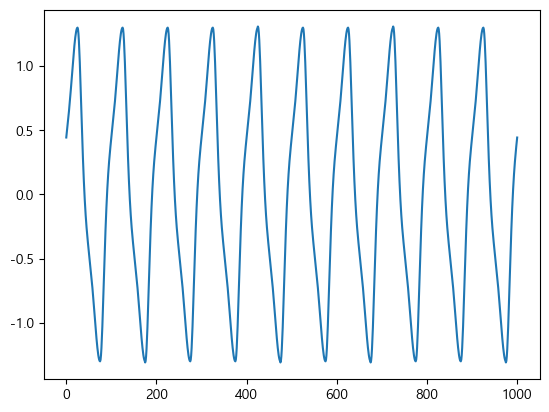

In [ ]:
plt.plot(y_te)

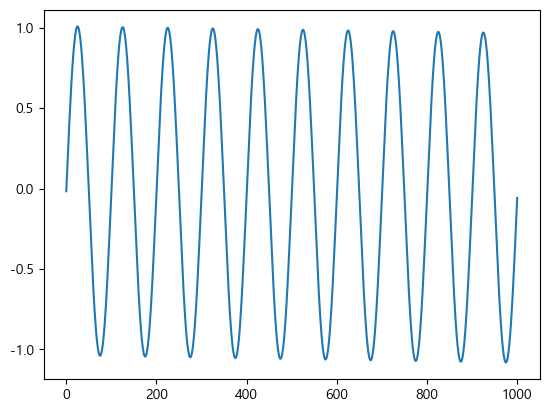

In [ ]:
plt.plot(y_pred[1])

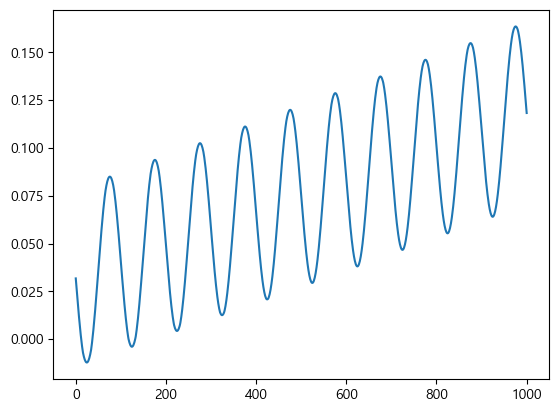

In [ ]:
plt.plot(y_pred[0])

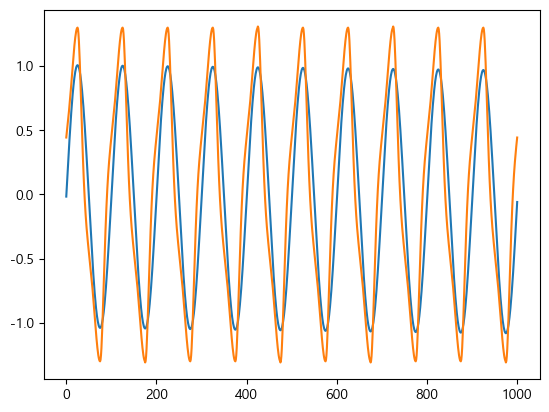

In [ ]:
plt.plot(y_pred[1])
plt.plot(y_te)

In [ ]:
y_pred[1]

<tf.Tensor: shape=(1001, 1), dtype=float32, numpy=
array([[-0.01652649],
       [ 0.0478172 ],
       [ 0.11191151],
       ...,
       [-0.1871374 ],
       [-0.12304571],
       [-0.05869463]], dtype=float32)>

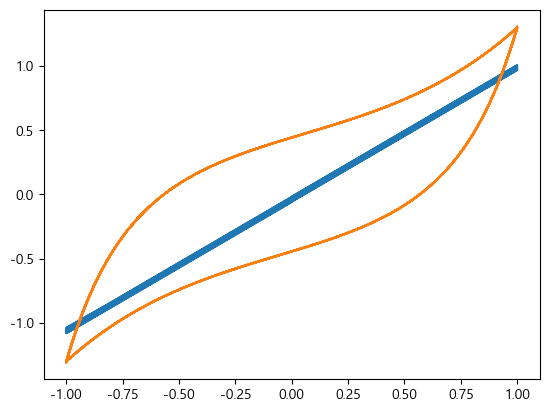

In [ ]:
plt.plot(test_x[:,0], y_pred[1])
plt.plot(test_x[:,0], y_te)